In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pysam
import numpy as np
import seaborn as sns
import pandas as pd

## simulate variance


In [3]:
def bootstrapSamp(counts_runA, cov_tot):
    np.random.seed()
    pb_runA = counts_runA/np.sum(counts_runA)
    _q = np.random.choice(range(0,len(counts_runA)),size=cov_tot,replace=True,p=pb_runA.astype(np.float))
    sim = np.zeros(len(pb_runA))
    for idx in _q:
        sim[idx] += 1
    return sim

def compute_FFC(base_run, pcr_run, include_nan=False):
    a = base_run/np.sum(base_run)
    b = pcr_run/np.sum(pcr_run)
    old_settings = np.seterr(divide='ignore',invalid='ignore')
    ampratio = b/a
    if include_nan == False:
        ffc = ampratio[np.isfinite(ampratio)]
    else:
        ffc = ampratio
    _=np.seterr(**old_settings)  # reset to default
    return ffc

## PCR sim
def binormSim(n, p, cyc=10):
    # simulate the number of molecules after "c" cycle
    # n: number of template molecules
    # p: probability of success PCR
    for i in range(cyc):
        n += np.random.binomial(n, p, 1)
    return n.item(0)

## full model, but copy number too big to run

In [ ]:
# should not use this data because it's from another ligation protcol
#PCR_highCopy = pd.read_csv("./data_PCREPCR/./F15_merged_170609.csv")


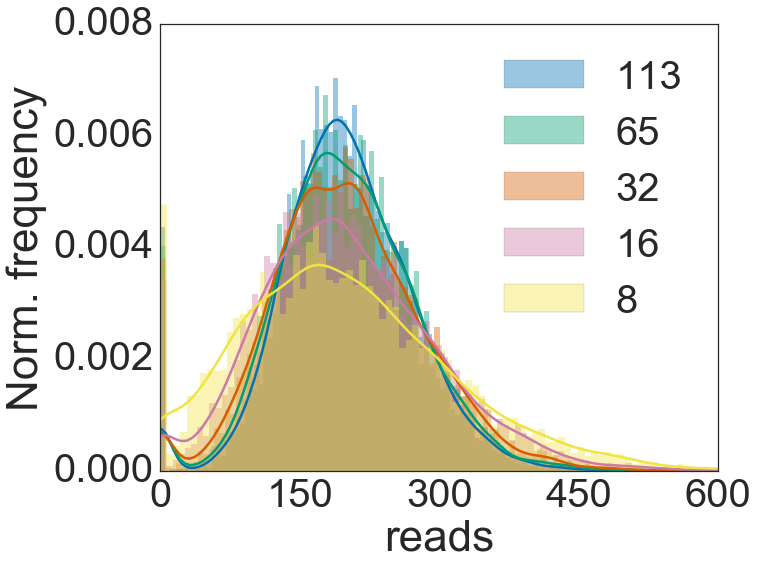

In [26]:
## plot distribution
nseqs = 7373
SEQCov = 200*nseqs

sns.set()
sns.set_palette("colorblind")
sns.set_context("notebook", font_scale=4.0, rc={"lines.linewidth": 2.5})
sns.set_style("white")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

label_texts = ["113", "65", "32", "16", "8"]
for i in range(1,6):
    exp_data = np.load("./npy/Bias"+str(i)+".npy")
    bsData = bootstrapSamp(exp_data, SEQCov)
    sns.distplot(bsData, bins = 100, hist_kws=dict(edgecolor="None"), label=label_texts[i-1])
    
ax.set_xlabel("reads")
ax.set_ylabel("Norm. frequency")
ax.legend(loc="upper right")
ax.set_xlim([0,600])
ax.set_ylim([0, 0.008])
ax.set_xticks(np.linspace(0,600,5))
ax.set_yticks(np.linspace(0,0.008,5))
fig.savefig("./figs/fig_DataDistribution.pdf", dpi=300, bbox_inches="tight", fmt="pdf")

In [17]:
label_texts[0]

113

## raw data

In [ ]:
nseqs = 7373
SEQCov = 200*nseqs
exp_data_list = []
CVs_exp = []
ffcSTDs_exp = []
rawCounts = np.load("./npy/Bias0.npy")
# totCopyN = SEQCov*nseqs
# bsRaw = bootstrapSamp(rawCounts, totCopyN)
for i in range(0,18):
    exp_data = np.load("./npy/Bias"+str(i)+".npy")
    bsData = bootstrapSamp(exp_data, SEQCov)
    CVs_exp.append(np.std(bsData)/np.mean(bsData))
    ffc = compute_FFC(bsRaw, bsData)
    ffcSTDs_exp.append(np.std(ffc))

CVs_exp = np.array(CVs_exp).reshape(3,6)
CVs_exp_mean = np.mean(CVs_exp, axis=0)
CVs_exp_std = np.std(CVs_exp, axis=0)
ffcSTDs_exp = np.array(ffcSTDs_exp).reshape(3,6)
ffcSTDs_exp_mean = np.mean(ffcSTDs_exp, axis=0)
ffcSTDs_exp_std = np.std(ffcSTDs_exp, axis=0)

# normalize data to the high copy number
normFFCs_exp_mean = [ffc/FFC_mean[0] for ffc in FFC_mean]
normFFCs_exp_std = [ffc/FFC_mean[0] for ffc in FFC_std]

normCVs_exp_mean = [CV/CV_mean[0] for CV in CV_mean]
normCVs_exp_std = [CV/CV_mean[0] for CV in CV_std]

In [7]:
sum(rawCounts)

2866139.0

In [ ]:
normCVs_sim = [CV/CVs_sim[0] for CV in CVs_sim]
normFFCs_sim = [ffc/ffcSTDs_sim[0] for ffc in ffcSTDs_sim]

In [ ]:
## simulate PCR

In [156]:
# simple PCR model
nseqs = 7373
p = 0.95
SEQCov = 200*nseqs

rawCounts = np.load("./npy/Bias0.npy")
bsRaw = bootstrapSamp(rawCounts, totCopyN)

avg_copyNs = [200, 113, 65, 32, 16, 8]
ffcSTDs_sim, CVs_sim, bsSEQ_counts_sim_list = [], [], []
for copyN in avg_copyNs:
    totCopyN = copyN*nseqs
    bsRaw_counts = bootstrapSamp(rawCounts, totCopyN)
    simPCR_counts1 = np.array([binormSim(int(count), p, 18) for count in bsRaw_counts]).astype(float)
    # sequencing
    bsSEQ_counts = bootstrapSamp(simPCR_counts1, SEQCov)
    # get statistics
    ffc = compute_FFC(bsRaw, bsSEQ_counts)
    ffcSTDs_sim.append(np.std(ffc))
    CVs_sim.append(np.std(bsSEQ_counts)/np.mean(bsSEQ_counts))
    bsSEQ_counts_sim_list.append(bsSEQ_counts)

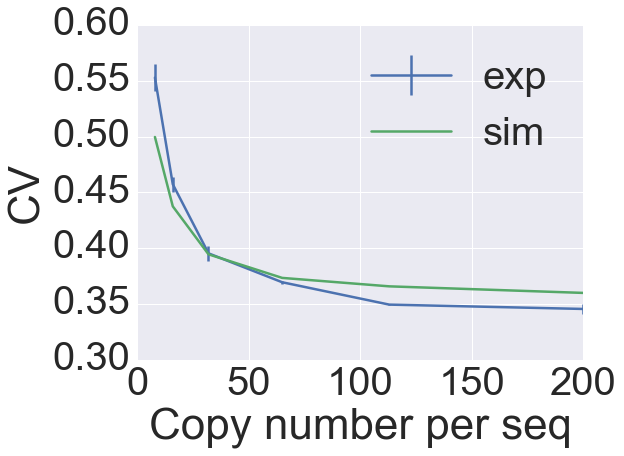

In [236]:
plt.matplotlib.rcParams.update({'font.size':22})
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
ax1.errorbar(avg_copyNs, CV_mean, CV_std, label="exp")
ax1.errorbar(avg_copyNs, CVs_sim, label="sim")
ax1.set_ylabel("CV")
ax1.set_xlabel("Copy number per seq")
ax1.legend()

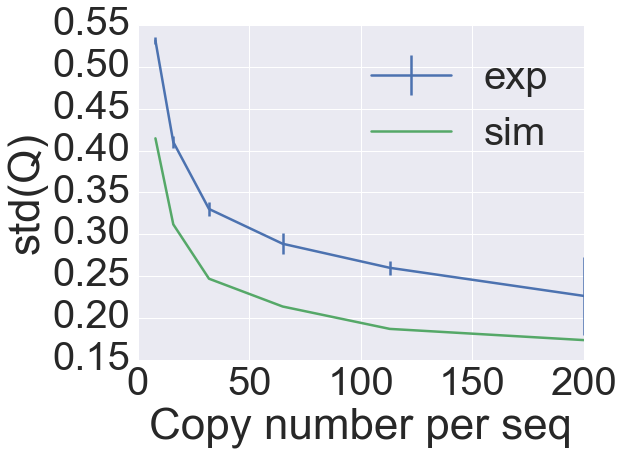

In [238]:
plt.matplotlib.rcParams.update({'font.size':22})
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
ax1.errorbar(avg_copyNs, FFC_mean, FFC_std, label="exp")
ax1.errorbar(avg_copyNs, ffcSTDs_sim, label="sim")
ax1.set_ylabel("std(Q)")
ax1.set_xlabel("Copy number per seq")
ax1.legend()

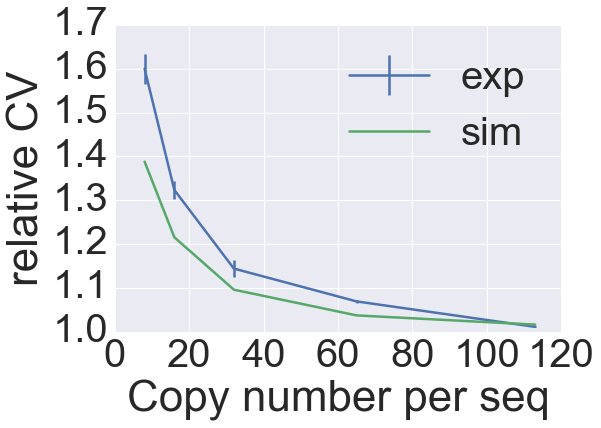

In [223]:
avg_copyNs = [200, 113, 65, 32, 16, 8]
sns.set_context("notebook", font_scale=4.0, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.errorbar(avg_copyNs[1:6],normCVs_exp_mean[1:6], normCVs_exp_std[1:6], label="exp")
ax.errorbar(avg_copyNs[1:6],normCVs_sim[1:6], label="sim")
#ax.plot(avg_copyNs,CVs_simFit, "o-", label="fit")
ax.set_ylabel("relative CV")
ax.set_xlabel("Copy number per seq")
ax.legend()
#fig.savefig("./figs/fig_sdQ.pdf", dpi=300, bbox_inches="tight", fmt="pdf")

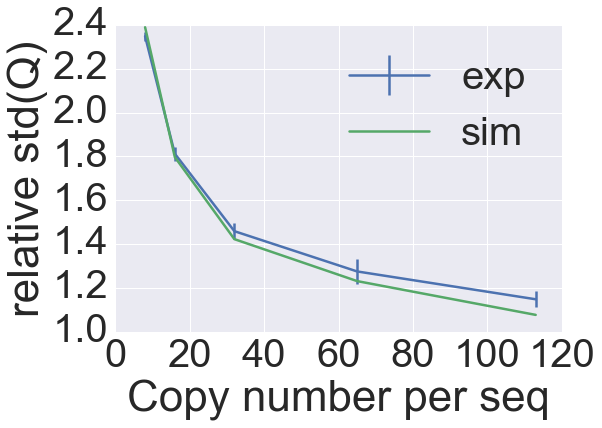

In [229]:
avg_copyNs = [200, 113, 65, 32, 16, 8]
sns.set_context("notebook", font_scale=4.0, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.errorbar(avg_copyNs[1:6],normFFCs_exp_mean[1:6], normFFCs_exp_std[1:6], label="exp")
ax.errorbar(avg_copyNs[1:6],normFFCs_sim[1:6], label="sim")
#ax.plot(avg_copyNs,CVs_simFit, "o-", label="fit")
ax.set_ylabel("relative std(Q)")
ax.set_xlabel("Copy number per seq")
ax.legend()
#fig.savefig("./figs/fig_sdQ.pdf", dpi=300, bbox_inches="tight", fmt="pdf")